In [1]:
from typing import List, Mapping, Callable
from itertools import zip_longest
from textwrap import dedent
from glob import iglob

from h5py import File
from ipywidgets import interactive, FloatSlider
import numpy as np
from numpy.random import normal, choice, rand
from numpy.polynomial.legendre import Legendre
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter
import matplotlib.pyplot as plt
from bokeh.io import push_notebook, show, output_notebook
from bokeh.plotting import figure
from bokeh.models import DataRange1d, LinearAxis, ColumnDataSource
import pandas as pd

from vmitools import (
    abel_inverse, finite_legendre_transform_in_theta,
    interp, tohist, transpose_linearly, transpose_to_drdomega, transpose_to_drdth,
    mrot, mhorshear, msqueeze,
)

output_notebook()

Loading BokehJS ...

/data/Step501N2/Run_203/work/Run_203.h5


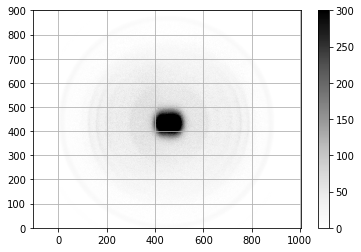

In [2]:
run = 203
filename = next(iglob(f"/data/*/Run_{run:03d}/work/Run_{run:03d}.h5"))
print(filename)

with File(filename, "r") as f:
    img = f["vmi_sum"][...]

xn, yn = img.shape
xedges = np.arange(xn + 1)
yedges = np.arange(yn + 1)

plt.figure()
plt.pcolormesh(img.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
plt.colorbar()
plt.clim(0, 300)
plt.show()

In [7]:
def transformer(
    hist: np.ndarray, xedges: np.ndarray, yedges: np.ndarray, zedges: np.ndarray,
) -> Callable[..., np.ndarray]:
    f = interp(hist, xedges, yedges)

    def ret(ph: float = 0, m: float = 0, k: float = 1, th: float = 0,
            x0: float = 0, y0: float = 0) -> np.ndarray:
        mat = mrot(ph) @ mrot(-th) @ mhorshear(m) @ msqueeze(k) @ mrot(th)
        g = transpose_linearly(f, mat, x0=np.array([x0, y0]))
        return tohist(g, zedges, zedges)
    return ret
        

def analysis(
    hist: np.ndarray,
    zedges: np.ndarray, redges: np.ndarray, thedges: np.ndarray,
    n: int,
) -> dict:
    dz = zedges[1:] - zedges[:-1]
    inverted = abel_inverse(hist, zedges) * dz[None, :]  # shape: (r, z)
    sliced = interp(inverted, zedges, zedges)  # (rho, z) -> intensity
    hist_indrdomega = tohist(
        transpose_to_drdomega(sliced), redges, thedges,
    )  # (r, th) -> intensity
    hist_indrdth = tohist(
        transpose_to_drdth(sliced), redges, thedges,
    )  # (r, th) -> intensity
    coeff_neg, coeff_pos, _ = finite_legendre_transform_in_theta(
        hist_indrdomega.T, thedges, n,
    )  # Shapes of returns: (n, r) (n, r) (n, th)
    return {
        "r": (redges[1:] + redges[:-1]) / 2,
        "dist": hist_indrdth.sum(1),
        **{f"beta{i}_neg": coeff_neg[i]/coeff_neg[0] for i in range(1, n)},
        **{f"beta{i}_pos": coeff_pos[i]/coeff_pos[0] for i in range(1, n)},
    }


zedges = np.arange(-400, 400 + 1)
transformed_by = transformer(gaussian_filter(img, 4), xedges, yedges, zedges)
redges, thedges = np.linspace(0, 400, 401), np.linspace(-np.pi, np.pi, 61)
n = 6
r = (redges[1:] + redges[:-1]) / 2
d = ColumnDataSource(data={
    "_r": r,
    "_dist": 0 * r,
    **{f"_beta{i}_neg": 0 * r for i in range(1, n)},
    **{f"_beta{i}_pos": 0 * r for i in range(1, n)},
})


@interactive
def plotit(
    x0 = FloatSlider(459, min=459-2, max=459+2, step=0.05),
    y0 = FloatSlider(432, min=432-2, max=432+2, step=0.05),
    th = FloatSlider(0, min=-3, max=3, step=0.05),
    k = FloatSlider(1, min=0.99, max=1.01, step=0.001),
    m = FloatSlider(0, min=-0.01, max=0.01, step=0.001),
    ph = FloatSlider(0, min=-3, max=3, step=0.05),
):
    for key, v in analysis(transformed_by(
        ph=ph, m=m, k=k, th=th, x0=x0, y0=y0,
    ), zedges, redges, thedges, n).items():
        d.data[f"_{key}"] = v
    print(dedent(f"""\
        x0: {x0: 8.3f}
        y0: {y0: 8.3f}
        th: {th: 8.3f}
         k: {k: 8.3f}
         m: {m: 8.3f}
        ph: {ph: 8.3f}\
    """))
    push_notebook()

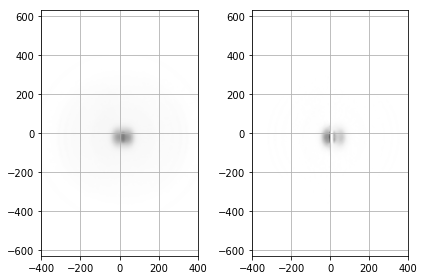

In [8]:
transformed = transformed_by(x0=440, y0=455)
dz = zedges[1:] - zedges[:-1]
inverted = abel_inverse(transformed, zedges) * dz[None, :]  # shape: (r, z)

plt.figure()
plt.subplot(121)
plt.pcolormesh(zedges, zedges, transformed.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
# plt.colorbar()
plt.clim(0, 1000)

plt.subplot(122)
plt.pcolormesh(zedges, zedges, inverted.T, cmap="Greys")
plt.grid(True)
plt.axis("equal")
# plt.colorbar()
plt.clim(0, 10)
plt.tight_layout()
plt.show()

In [9]:
p = figure(x_range=[0, 400], y_range=[-1, 4])
p.add_layout(LinearAxis(y_range_name="extra_y"), "left")
p.extra_y_ranges = {"extra_y": DataRange1d()}
p.line("_r", "_beta1_neg", source=d, color="#1f77b4", legend="beta1 (neg)")
p.line("_r", "_beta1_pos", source=d, color="#1f77b4", legend="beta1 (pos)")
p.line("_r", "_beta2_neg", source=d, color="#ff7f0e", legend="beta2 (neg)")
p.line("_r", "_beta2_pos", source=d, color="#ff7f0e", legend="beta2 (pos)")
p.line("_r", "_beta3_neg", source=d, color="#2ca02c", legend="beta3 (neg)")
p.line("_r", "_beta3_pos", source=d, color="#2ca02c", legend="beta3 (pos)")
p.line("_r", "_beta4_neg", source=d, color="#d62728", legend="beta4 (neg)")
p.line("_r", "_beta4_pos", source=d, color="#d62728", legend="beta4 (pos)")
p.line("_r", "_dist", source=d, y_range_name="extra_y", color="black", legend="dist")
p.legend.click_policy = "hide"
show(p, notebook_handle=True)
plotit

interactive(children=(FloatSlider(value=459.0, description='x0', max=461.0, min=457.0, step=0.05), FloatSlider…

In [50]:
def integrateit(d, fr, to):
    where = (fr < d["_r"]) & (d["_r"] < to)
    return {k[1: ]: np.average(d[k][where], weights=d["_dist"][where])
            for k in d if k.startswith("_beta")}


df = pd.DataFrame(
    [
        {"_fr": fr, "_to": to, **integrateit(d.data, fr, to)}
        for fr, to in [
            [140, 180],
        ]
    ]
)
df.to_excel(saveas)
df

,_fr,_to,beta1_neg,beta1_pos,beta2_neg,beta2_pos,beta3_neg,beta3_pos,beta4_neg,beta4_pos,beta5_neg,beta5_pos
0,140,180,-0.097781,0.073729,2.580718,2.552483,0.013546,0.059138,1.670001,1.627093,0.223542,0.153616
